# DNS Detection Pipeline
Edward Crowder & Ahmad Chaiban

The implementation of our project is contained in this portion of the project. 

Data Source: 
- http://205.174.165.80/CICDataset/DoHBrw-2020/Dataset/

- https://www.unb.ca/cic/datasets/dohbrw-2020.html

In [1]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from imblearn.under_sampling import ClusterCentroids
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d
from IPython.display import HTML
import matplotlib.animation as animation
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import normalize

# Importing the data and Preprocessing

The dataset used for this implementation includes DoH protocol captures of Benign-DoH and Malicious-DoH. The browsers and tools used to capture this traffic include Google Chrome, Mozilla Firefox, dns2tcp, DNSCat2, and Iodine while the servers used to respond to DoH requests are AdGuard, Cloudflare, Google DNS, and Quad9.

At this stage the data was imported and preprocessed to set up for the various analysis, feature selection and classification techniques (both supervised and unsupervised learning). 

In [2]:
data_ben = pd.read_csv('cic-mal-benign-dns/l2-benign.csv', sep=',')
print(f'Number of benign = {len(data_ben)}')
data_ben.head()

Number of benign = 19807


SourceIP    DestinationIP  SourcePort  DestinationPort  \
0   192.168.20.191  176.103.130.131       50749              443   
1   192.168.20.191  176.103.130.131       50749              443   
2   192.168.20.191  176.103.130.131       50749              443   
3   192.168.20.191  176.103.130.131       50749              443   
4  176.103.130.131   192.168.20.191         443            50749   

             TimeStamp    Duration  FlowBytesSent  FlowSentRate  \
0  2020-01-14 15:49:11   95.081550          62311    655.342703   
1  2020-01-14 15:50:52  122.309318          93828    767.136973   
2  2020-01-14 15:52:55  120.958413          38784    320.639127   
3  2020-01-14 15:54:56  110.501080          61993    561.017141   
4  2020-01-14 15:56:46   54.229891          83641   1542.341289   

   FlowBytesReceived  FlowReceivedRate  ...  PacketTimeCoefficientofVariation  \
0              65358        687.388878  ...                          0.574626   
1             101232        827.672018  ...                          0.509047   
2              38236        316.108645  ...                          0.732636   
3              69757        631.278898  ...                          0.646859   
4              76804       1416.266907  ...                          0.507334   

   ResponseTimeTimeVariance  ResponseTimeTimeStandardDeviation  \
0                  0.001053                           0.032457   
1                  0.001170                           0.034200   
2                  0.000785                           0.028021   
3                  0.000411                           0.020274   
4                  0.079079                           0.281209   

   ResponseTimeTimeMean  ResponseTimeTimeMedian  ResponseTimeTimeMode  \
0              0.027624                0.026854              0.026822   
1              0.024387                0.021043              0.026981   
2              0.029238                0.026921              0.026855   
3              0.019925                0.019268              0.026918   
4              0.025930                0.000047              0.000021   

   ResponseTimeTimeSkewFromMedian  ResponseTimeTimeSkewFromMode  \
0                        0.071187                      0.024715   
1                        0.293297                     -0.075845   
2                        0.248064                      0.085061   
3                        0.097199                     -0.344926   
4                        0.276133                      0.092135   

   ResponseTimeTimeCoefficientofVariation   Label  
0                                1.174948  Benign  
1                                1.402382  Benign  
2                                0.958348  Benign  
3                                1.017535  Benign  
4                               10.844829  Benign  

[5 rows x 35 columns]

In [3]:
data_mal = pd.read_csv('cic-mal-benign-dns/l2-malicious.csv', sep=',')
print(f'Number of malicious = {len(data_mal)}')
data_mal.head()

Number of malicious = 249836


SourceIP   DestinationIP  SourcePort  DestinationPort  \
0  192.168.20.205         8.8.4.4       41018              443   
1         8.8.4.4  192.168.20.205         443            41018   
2         8.8.4.4  192.168.20.205         443            41018   
3         8.8.4.4  192.168.20.205         443            41018   
4         8.8.4.4  192.168.20.205         443            41018   

             TimeStamp    Duration  FlowBytesSent  FlowSentRate  \
0  2020-03-25 04:40:42  120.731389          46446    384.705257   
1  2020-03-25 04:42:42  120.052751         470548   3919.510349   
2  2020-03-25 04:44:42  120.034398         747083   6223.907584   
3  2020-03-25 04:46:42  120.004804         745382   6211.268009   
4  2020-03-25 04:48:42  120.025620         749888   6247.732776   

   FlowBytesReceived  FlowReceivedRate  ...  PacketTimeCoefficientofVariation  \
0              85465        707.893786  ...                          0.622162   
1             227661       1896.341384  ...                          0.331509   
2             355181       2958.993471  ...                          0.579348   
3             354606       2954.931704  ...                          0.580188   
4             356531       2970.457474  ...                          0.578922   

   ResponseTimeTimeVariance  ResponseTimeTimeStandardDeviation  \
0                  0.000070                           0.008369   
1                  0.023756                           0.154130   
2                  0.000276                           0.016611   
3                  0.000271                           0.016473   
4                  0.000271                           0.016458   

   ResponseTimeTimeMean  ResponseTimeTimeMedian  ResponseTimeTimeMode  \
0              0.011880                0.015244              0.015221   
1              0.037553                0.000049              0.000039   
2              0.011986                0.000048              0.000030   
3              0.011724                0.000049              0.000031   
4              0.011725                0.000048              0.000031   

   ResponseTimeTimeSkewFromMedian  ResponseTimeTimeSkewFromMode  \
0                       -1.205904                     -0.399220   
1                        0.729988                      0.243394   
2                        2.156008                      0.719753   
3                        2.126128                      0.709802   
4                        2.128463                      0.710521   

   ResponseTimeTimeCoefficientofVariation      Label  
0                                0.704513  Malicious  
1                                4.104293  Malicious  
2                                1.385888  Malicious  
3                                1.405118  Malicious  
4                                1.403698  Malicious  

[5 rows x 35 columns]

## Feature list

In [4]:
data_mal.columns

Index(['SourceIP', 'DestinationIP', 'SourcePort', 'DestinationPort',
       'TimeStamp', 'Duration', 'FlowBytesSent', 'FlowSentRate',
       'FlowBytesReceived', 'FlowReceivedRate', 'PacketLengthVariance',
       'PacketLengthStandardDeviation', 'PacketLengthMean',
       'PacketLengthMedian', 'PacketLengthMode', 'PacketLengthSkewFromMedian',
       'PacketLengthSkewFromMode', 'PacketLengthCoefficientofVariation',
       'PacketTimeVariance', 'PacketTimeStandardDeviation', 'PacketTimeMean',
       'PacketTimeMedian', 'PacketTimeMode', 'PacketTimeSkewFromMedian',
       'PacketTimeSkewFromMode', 'PacketTimeCoefficientofVariation',
       'ResponseTimeTimeVariance', 'ResponseTimeTimeStandardDeviation',
       'ResponseTimeTimeMean', 'ResponseTimeTimeMedian',
       'ResponseTimeTimeMode', 'ResponseTimeTimeSkewFromMedian',
       'ResponseTimeTimeSkewFromMode',
       'ResponseTimeTimeCoefficientofVariation', 'Label'],
      dtype='object')

In [95]:
print(f"Features given by the original dataset = {len(data_mal.columns)}")

Features given by the original dataset = 35


## Merging Data

* Merging data for initial tests. 
* Benign to 0 and Malicious to 1.
* Dropping SourceIP and DestinationIP. 

In [7]:
data = pd.concat([data_ben, data_mal]).dropna()

data['Label'] = data['Label'].apply(lambda x: 1 if x == 'Malicious' else 0)

print(len(data[data['Label'] == 1]))
print(len(data[data['Label'] == 0]))
data = data.drop(columns=['SourceIP', 'DestinationIP', 'TimeStamp'])

data.head(5)

249553
19746


SourcePort  DestinationPort    Duration  FlowBytesSent  FlowSentRate  \
0       50749              443   95.081550          62311    655.342703   
1       50749              443  122.309318          93828    767.136973   
2       50749              443  120.958413          38784    320.639127   
3       50749              443  110.501080          61993    561.017141   
4         443            50749   54.229891          83641   1542.341289   

   FlowBytesReceived  FlowReceivedRate  PacketLengthVariance  \
0              65358        687.388878           7474.676771   
1             101232        827.672018          10458.118598   
2              38236        316.108645           7300.293933   
3              69757        631.278898           8499.282518   
4              76804       1416.266907           8052.745751   

   PacketLengthStandardDeviation  PacketLengthMean  ...  \
0                      86.456213        135.673751  ...   
1                     102.264943        141.245474  ...   
2                      85.441758        133.715278  ...   
3                      92.191553        139.123548  ...   
4                      89.737092        138.913420  ...   

   PacketTimeCoefficientofVariation  ResponseTimeTimeVariance  \
0                          0.574626                  0.001053   
1                          0.509047                  0.001170   
2                          0.732636                  0.000785   
3                          0.646859                  0.000411   
4                          0.507334                  0.079079   

   ResponseTimeTimeStandardDeviation  ResponseTimeTimeMean  \
0                           0.032457              0.027624   
1                           0.034200              0.024387   
2                           0.028021              0.029238   
3                           0.020274              0.019925   
4                           0.281209              0.025930   

   ResponseTimeTimeMedian  ResponseTimeTimeMode  \
0                0.026854              0.026822   
1                0.021043              0.026981   
2                0.026921              0.026855   
3                0.019268              0.026918   
4                0.000047              0.000021   

   ResponseTimeTimeSkewFromMedian  ResponseTimeTimeSkewFromMode  \
0                        0.071187                      0.024715   
1                        0.293297                     -0.075845   
2                        0.248064                      0.085061   
3                        0.097199                     -0.344926   
4                        0.276133                      0.092135   

   ResponseTimeTimeCoefficientofVariation  Label  
0                                1.174948      0  
1                                1.402382      0  
2                                0.958348      0  
3                                1.017535      0  
4                               10.844829      0  

[5 rows x 32 columns]

In [8]:
X, y = data.drop(columns=['Label']), data['Label']

In [9]:
X

SourcePort  DestinationPort    Duration  FlowBytesSent  FlowSentRate  \
0            50749              443   95.081550          62311    655.342703   
1            50749              443  122.309318          93828    767.136973   
2            50749              443  120.958413          38784    320.639127   
3            50749              443  110.501080          61993    561.017141   
4              443            50749   54.229891          83641   1542.341289   
...            ...              ...         ...            ...           ...   
249831         443            33926  120.653838          78776    652.909193   
249832         443            33926  120.718680          78719    652.086322   
249833         443            33926  120.645723          78808    653.218349   
249834         443            33926  120.652326          77281    640.526400   
249835         443            33926   30.951614          23514    759.701901   

        FlowBytesReceived  FlowReceivedRate  PacketLengthVariance  \
0                   65358        687.388878           7474.676771   
1                  101232        827.672018          10458.118598   
2                   38236        316.108645           7300.293933   
3                   69757        631.278898           8499.282518   
4                   76804       1416.266907           8052.745751   
...                   ...               ...                   ...   
249831              46073        381.861040           7979.982650   
249832              46047        381.440553           8141.129962   
249833              46118        382.259718           8648.833760   
249834              46015        381.385105          11417.273333   
249835              13884        448.571115           8107.633456   

        PacketLengthStandardDeviation  PacketLengthMean  ...  \
0                           86.456213        135.673751  ...   
1                          102.264943        141.245474  ...   
2                           85.441758        133.715278  ...   
3                           92.191553        139.123548  ...   
4                           89.737092        138.913420  ...   
...                               ...               ...  ...   
249831                      89.330749        121.566699  ...   
249832                      90.228210        121.604288  ...   
249833                      92.999106        122.476471  ...   
249834                     106.851642        125.300813  ...   
249835                      90.042398        121.029126  ...   

        PacketTimeSkewFromMode  PacketTimeCoefficientofVariation  \
0                     1.682529                          0.574626   
1                     0.772748                          0.509047   
2                     1.353607                          0.732636   
3                     1.148758                          0.646859   
4                     1.573873                          0.507334   
...                        ...                               ...   
249831                1.627348                          0.614497   
249832                1.623502                          0.615953   
249833                1.547221                          0.646320   
249834                1.685458                          0.593311   
249835                1.396885                          0.715879   

        ResponseTimeTimeVariance  ResponseTimeTimeStandardDeviation  \
0                   1.053454e-03                           0.032457   
1                   1.169641e-03                           0.034200   
2                   7.851554e-04                           0.028021   
3                   4.110453e-04                           0.020274   
4                   7.907866e-02                           0.281209   
...                          ...                                ...   
249831              8.716113e-09                           0.000093   
249832              8.737216e-07                           0.000

In [10]:
original_features = X
original_labels = y

# Unsupervised Learning

## t-SNE 2D & 3D

After the initial preprocessing, t-SNE was applied to the data set in order to visualize the features. 

In [11]:
# X_embedded = TSNE(n_components = 2, random_state = 0).fit_transform(X)

In [12]:
# pd.DataFrame(X_embedded).to_csv('tSNE Initial.csv', sep=',')
X_embedded = np.array(pd.read_csv('tSNE initial.csv', sep=',').drop(columns=['Unnamed: 0']))

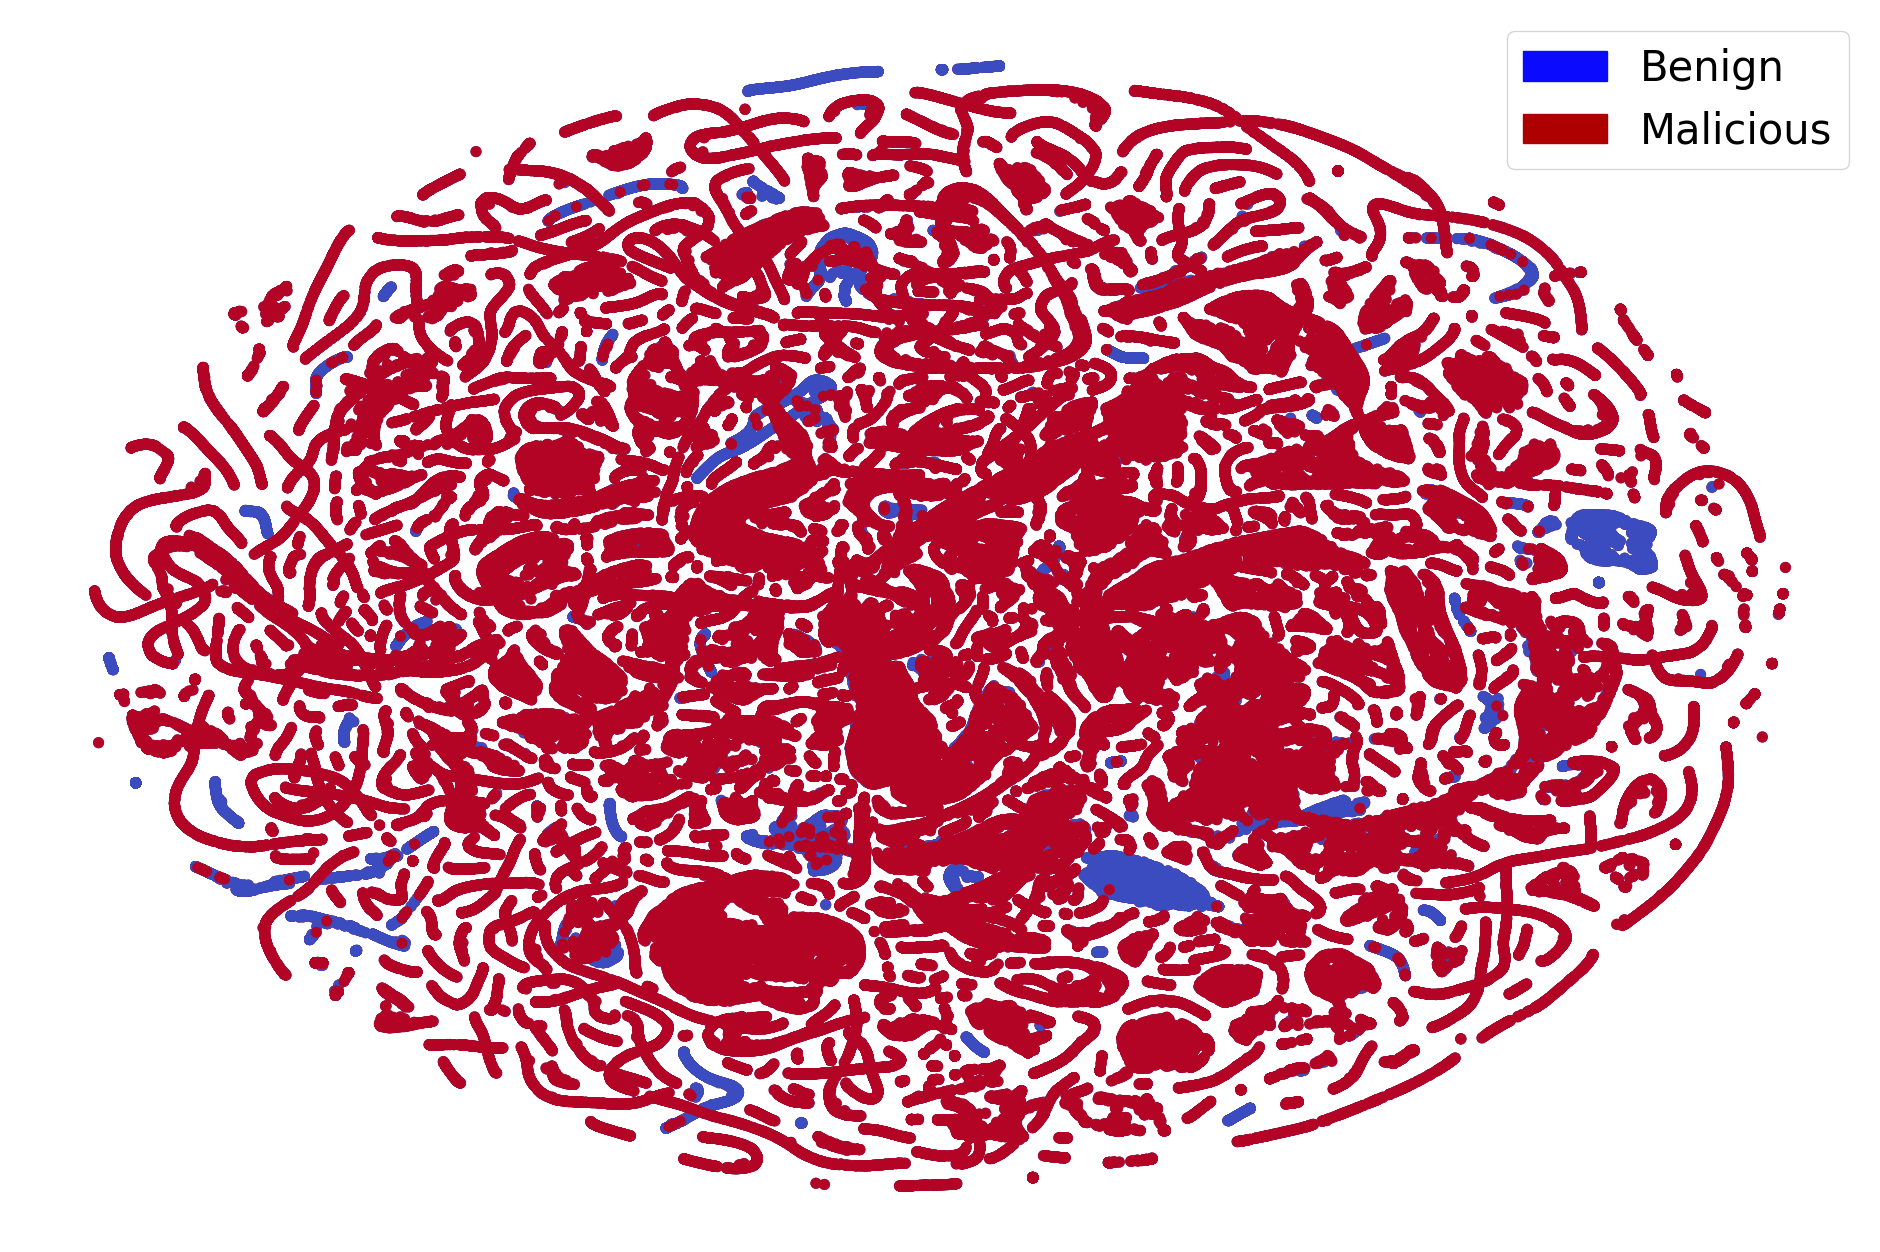

In [118]:
f, ax = plt.subplots(figsize=(24,16))

blue_patch = mpatches.Patch(color='#0A0AFF', label='Benign')
red_patch = mpatches.Patch(color='#AF0000', label='Malicious')

# blue_patch = mpatches.Patch(color='#eeeeee', label='Benign')
# red_patch = mpatches.Patch(color='#380f78', label='Malicious')

#cmap = 'Purples'

ax.scatter(X_embedded[:,0], X_embedded[:,1], c=(y == 0), cmap='coolwarm', label='Benign', linewidths=2)
ax.scatter(X_embedded[:,0], X_embedded[:,1], c=(y == 1), cmap='coolwarm', label='Malicious', linewidths=2)
# ax.set_title('t-SNE', fontsize=14)

ax.grid(False)
ax.axis('off')

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])

ax.legend(handles=[blue_patch, red_patch], fontsize=30)

In [14]:
# X_embedded_3d = TSNE(n_components = 3, random_state = 0).fit_transform(X)

In [15]:
# pd.DataFrame(X_embedded_3d).to_csv('tSNE_initial_3d.csv', sep=',')
X_embedded_3d = np.array(pd.read_csv('tSNE_initial_3d.csv', sep=',').drop(columns=['Unnamed: 0']))

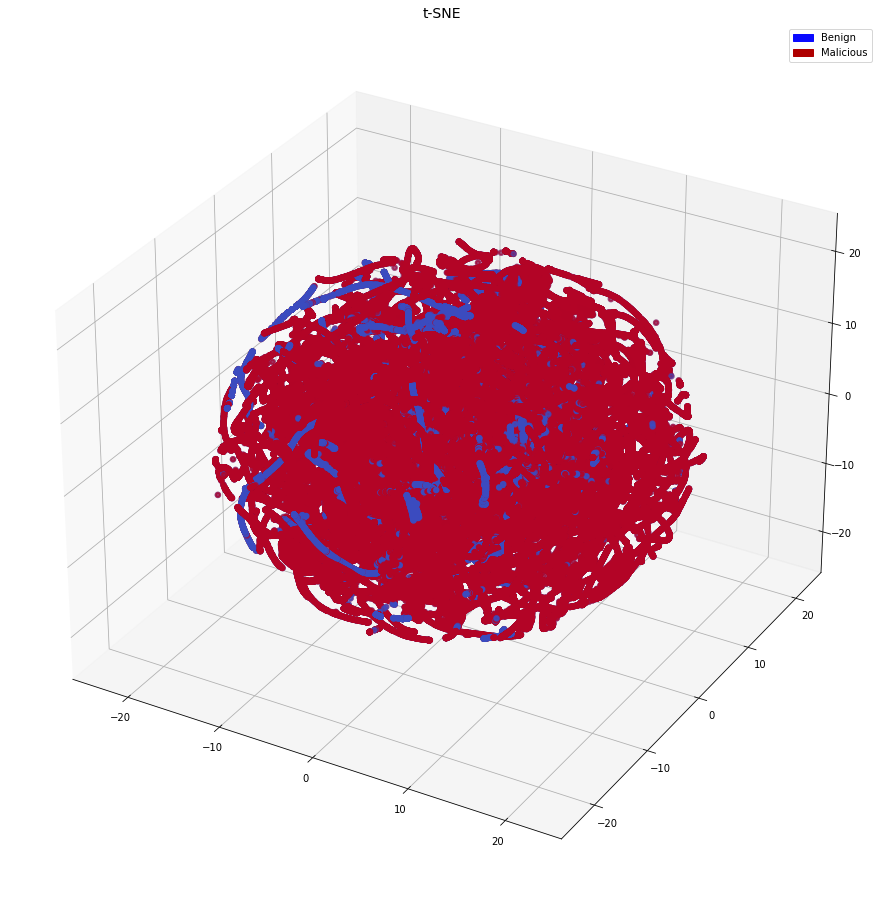

In [16]:
fig = plt.figure(figsize = (24,16))
ax = fig.add_subplot(111, projection='3d')

blue_patch = mpatches.Patch(color='#0A0AFF', label='Benign')
red_patch = mpatches.Patch(color='#AF0000', label='Malicious')

ax.scatter(X_embedded_3d[:,0], X_embedded_3d[:,1], X_embedded_3d[:,2], c=(y == 0), cmap= 'coolwarm', label='Benign', linewidths=2)
ax.scatter(X_embedded_3d[:,0], X_embedded_3d[:,1], X_embedded_3d[:,2], c=(y == 1), cmap='coolwarm', label='Malicious', linewidths=2)
ax.set_title('t-SNE', fontsize=14)

ax.grid(True)

ax.legend(handles=[blue_patch, red_patch])

## Undersampling

Undersampling the dataset is a vital step. Not only is the data slightly imbalanced, but a method such as cluster centroids allows for outlier elimination as well as clearer visualization with unsupervised learning methods such as t-SNE.

In [17]:
# cluster_centroids = ClusterCentroids(random_state = 42)
# X_undersam, y_underSam = cluster_centroids.fit_resample(X, y)

In [18]:
# X_undersam.to_csv('Under-Sampled-Data-features.csv', header = True)
# y_underSam.to_csv('Under-Sampled-Data-labels.csv', header = True)

X_undersam_saved = pd.read_csv('Under-Sampled-Data-features.csv', sep=',').drop(columns=['Unnamed: 0'])
y_underSam_saved = pd.read_csv('Under-Sampled-Data-labels.csv', sep=',').drop(columns=['Unnamed: 0'])['Label']

## t-SNE (After undersampling)

After undersampling, t-SNE was applied once more, and yielded both 2D and 3D visualizations that showed some clear separations in both the benign and malicious data.

In [19]:
# X_res_embedded = TSNE(n_components = 2, random_state = 0).fit_transform(X_undersam_saved)

In [20]:
# pd.DataFrame(X_res_embedded).to_csv('tSNE_undersampled_2D.csv', sep=',')
X_res_embedded_saved = np.array(pd.read_csv('tSNE_undersampled_2D.csv', sep=',').drop(columns=['Unnamed: 0']))

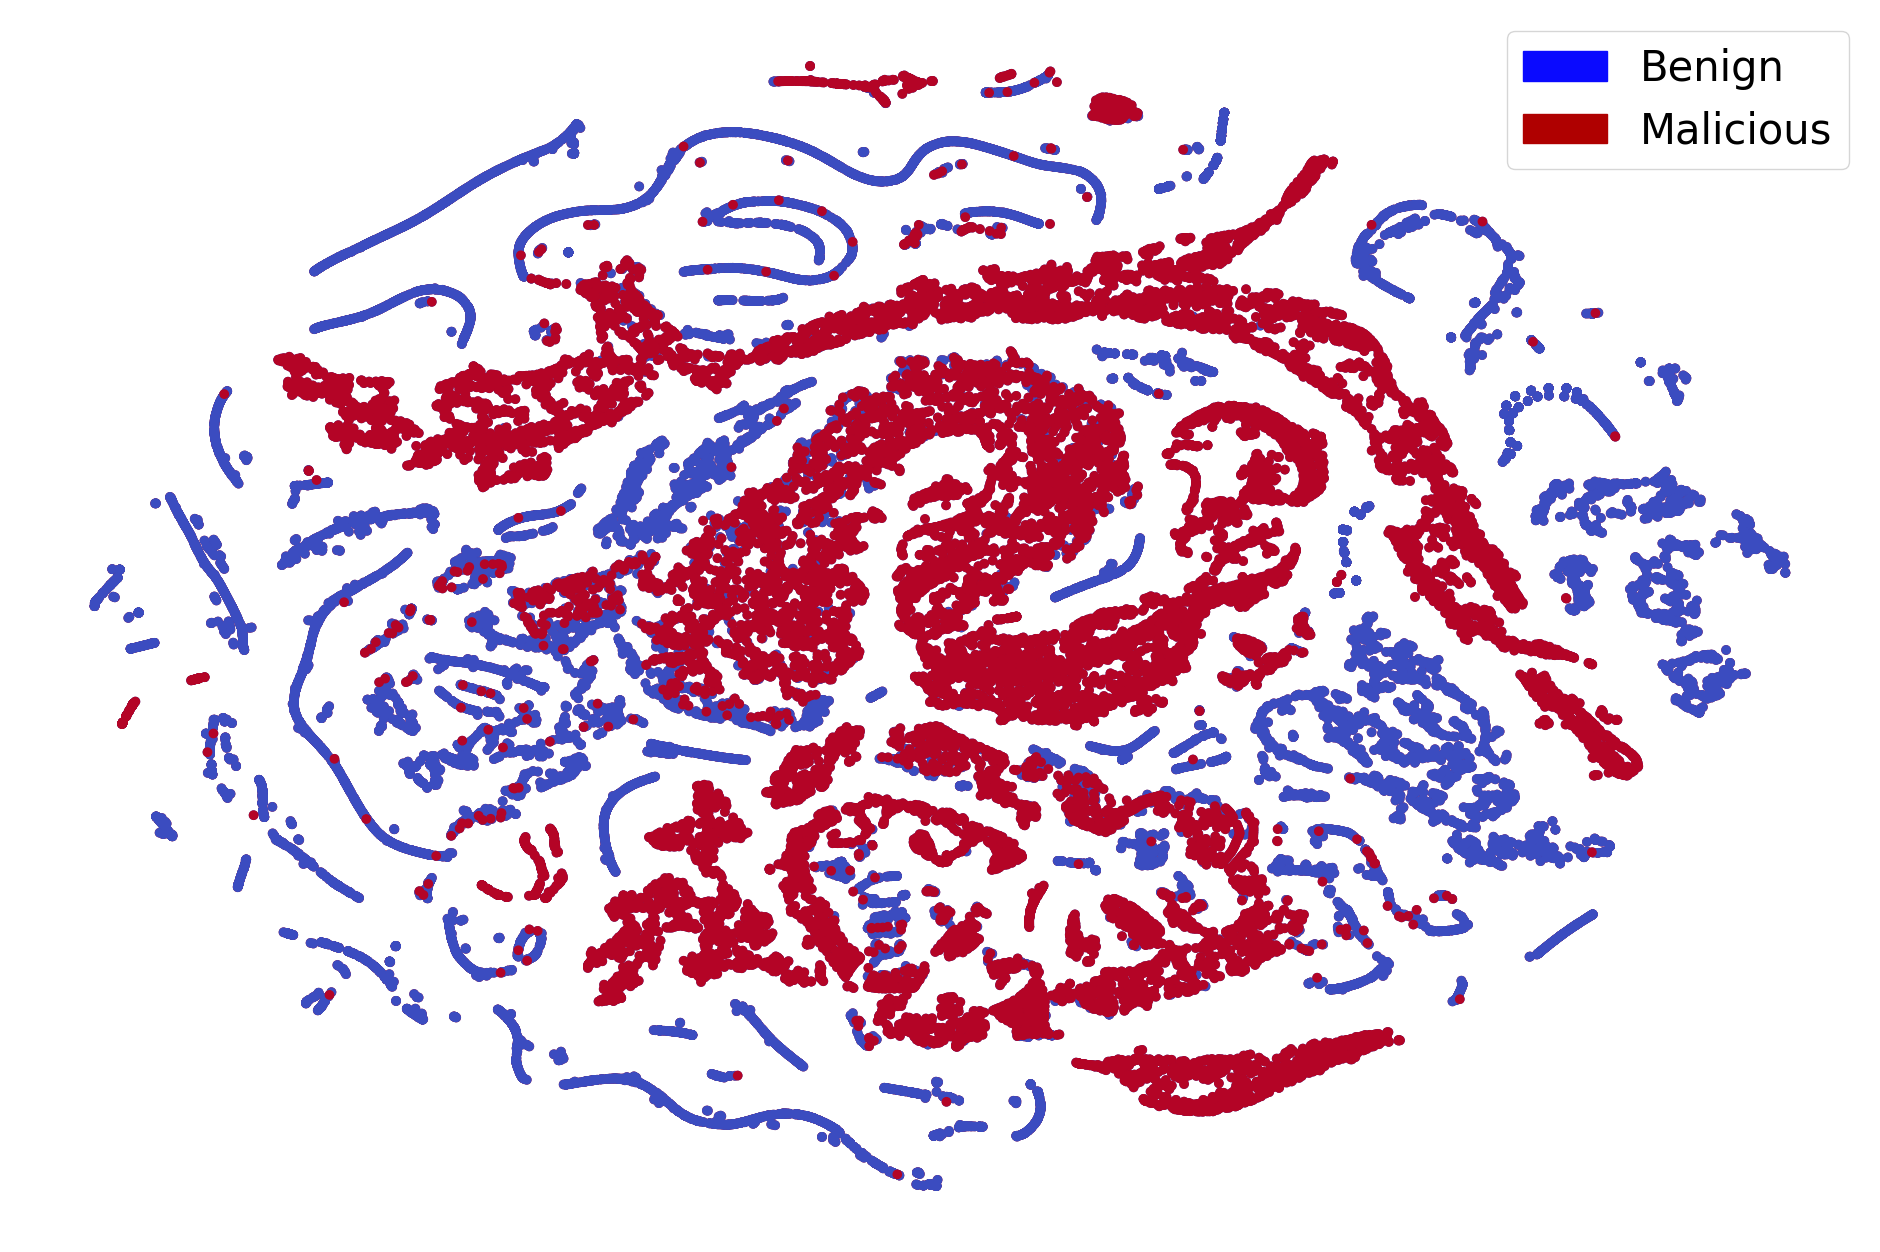

In [117]:
f, ax = plt.subplots(figsize=(24,16))

# plt.style.use('dark_background')

blue_patch = mpatches.Patch(color='#0A0AFF', label='Benign')
red_patch = mpatches.Patch(color='#AF0000', label='Malicious')

ax.scatter(X_res_embedded_saved[:,0], X_res_embedded_saved[:,1], c=(y_underSam_saved == 0), cmap='coolwarm', label='Benign', linewidths=1)
ax.scatter(X_res_embedded_saved[:,0], X_res_embedded_saved[:,1], c=(y_underSam_saved == 1), cmap='coolwarm', label='Malicious', linewidths=1)
# ax.set_title('t-SNE of Undersampled Data', fontsize=30)

ax.grid(False)

ax.axis('off')

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])

# plt.legend(loc=2, prop={'size': 20})

ax.legend(handles=[blue_patch, red_patch], fontsize=30)

In [22]:
# X_res_embedded_3d = TSNE(n_components = 3, random_state = 0).fit_transform(X_undersam_saved)

In [23]:
# pd.DataFrame(X_res_embedded_3d).to_csv('tSNE_3d_undersampled.csv', sep=',')
X_res_embedded_3d_saved = np.array(pd.read_csv('tSNE_3d_undersampled.csv', sep=',').drop(columns=['Unnamed: 0']))

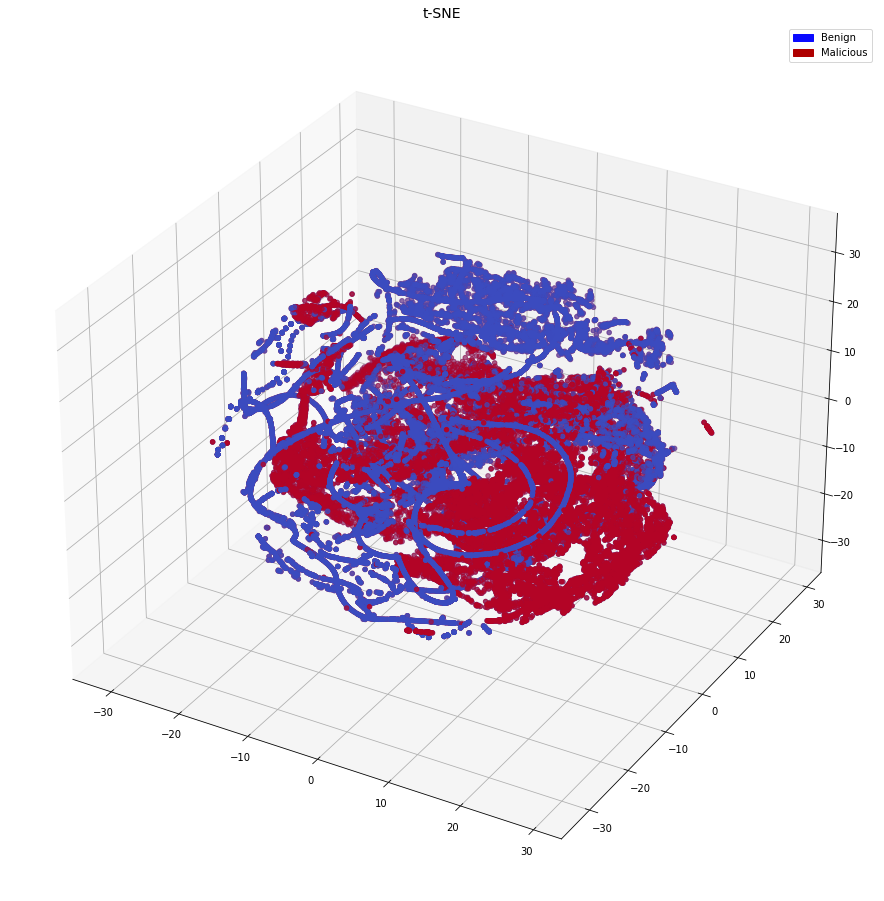

In [24]:
fig = plt.figure(figsize = (24,16))
ax = fig.add_subplot(111, projection='3d')

blue_patch = mpatches.Patch(color='#0A0AFF', label='Benign')
red_patch = mpatches.Patch(color='#AF0000', label='Malicious')

ax.scatter(X_res_embedded_3d_saved[:,0], X_res_embedded_3d_saved[:,1], X_res_embedded_3d_saved[:,2], c=(y_underSam_saved == 0), cmap= 'coolwarm', label='Benign', linewidths=1)
ax.scatter(X_res_embedded_3d_saved[:,0], X_res_embedded_3d_saved[:,1], X_res_embedded_3d_saved[:,2], c=(y_underSam_saved == 1), cmap='coolwarm', label='Malicious', linewidths=1)
ax.set_title('t-SNE', fontsize=14)

ax.grid(True)

ax.legend(handles=[blue_patch, red_patch])

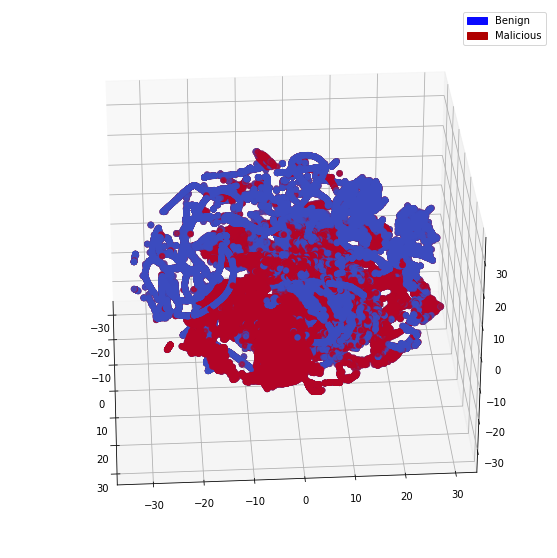

In [33]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111, projection='3d')

# load some test data for demonstration and plot a wireframe
X, Y, Z = axes3d.get_test_data(0.1)
#ax.grid(False)
#ax.set_axis_off()

blue_patch = mpatches.Patch(color='#0A0AFF', label='Benign')
red_patch = mpatches.Patch(color='#AF0000', label='Malicious')

def init():
    ax.scatter(X_res_embedded_3d_saved[:,0], X_res_embedded_3d_saved[:,1], X_res_embedded_3d_saved[:,2], c=(y_underSam_saved == 0), cmap= 'coolwarm', label='Benign', linewidths=2)
    ax.scatter(X_res_embedded_3d_saved[:,0], X_res_embedded_3d_saved[:,1], X_res_embedded_3d_saved[:,2], c=(y_underSam_saved == 1), cmap='coolwarm', label='Malicious', linewidths=2)
    ax.legend(handles=[blue_patch, red_patch])
    
    ax.grid(True)

    # Hide axes ticks
#     ax.set_xticks([])
#     ax.set_yticks([])

    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

# Animate
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=100, interval=100, blit=True)    

HTML(ani.to_html5_video())

In [34]:
# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=10, metadata=dict(artist='Edward and Ahmad'), bitrate=1800)
# ani.save('tSNE Demo.mp4', writer=writer) 

## Normalize

An important step for improving the classification is simply to normalize this data.  

In [25]:
X_undersam_saved_normalized = pd.DataFrame(normalize(X_undersam_saved, norm='l2', axis=1))
X_undersam_saved_normalized.columns = X_undersam_saved.columns

# Feature selection

In order to provide the most optimal results that require the least number of, and most descriptive, features, the pearson correlation matrix was utilized for feature selection. 

## Pearson Correlation Matrix

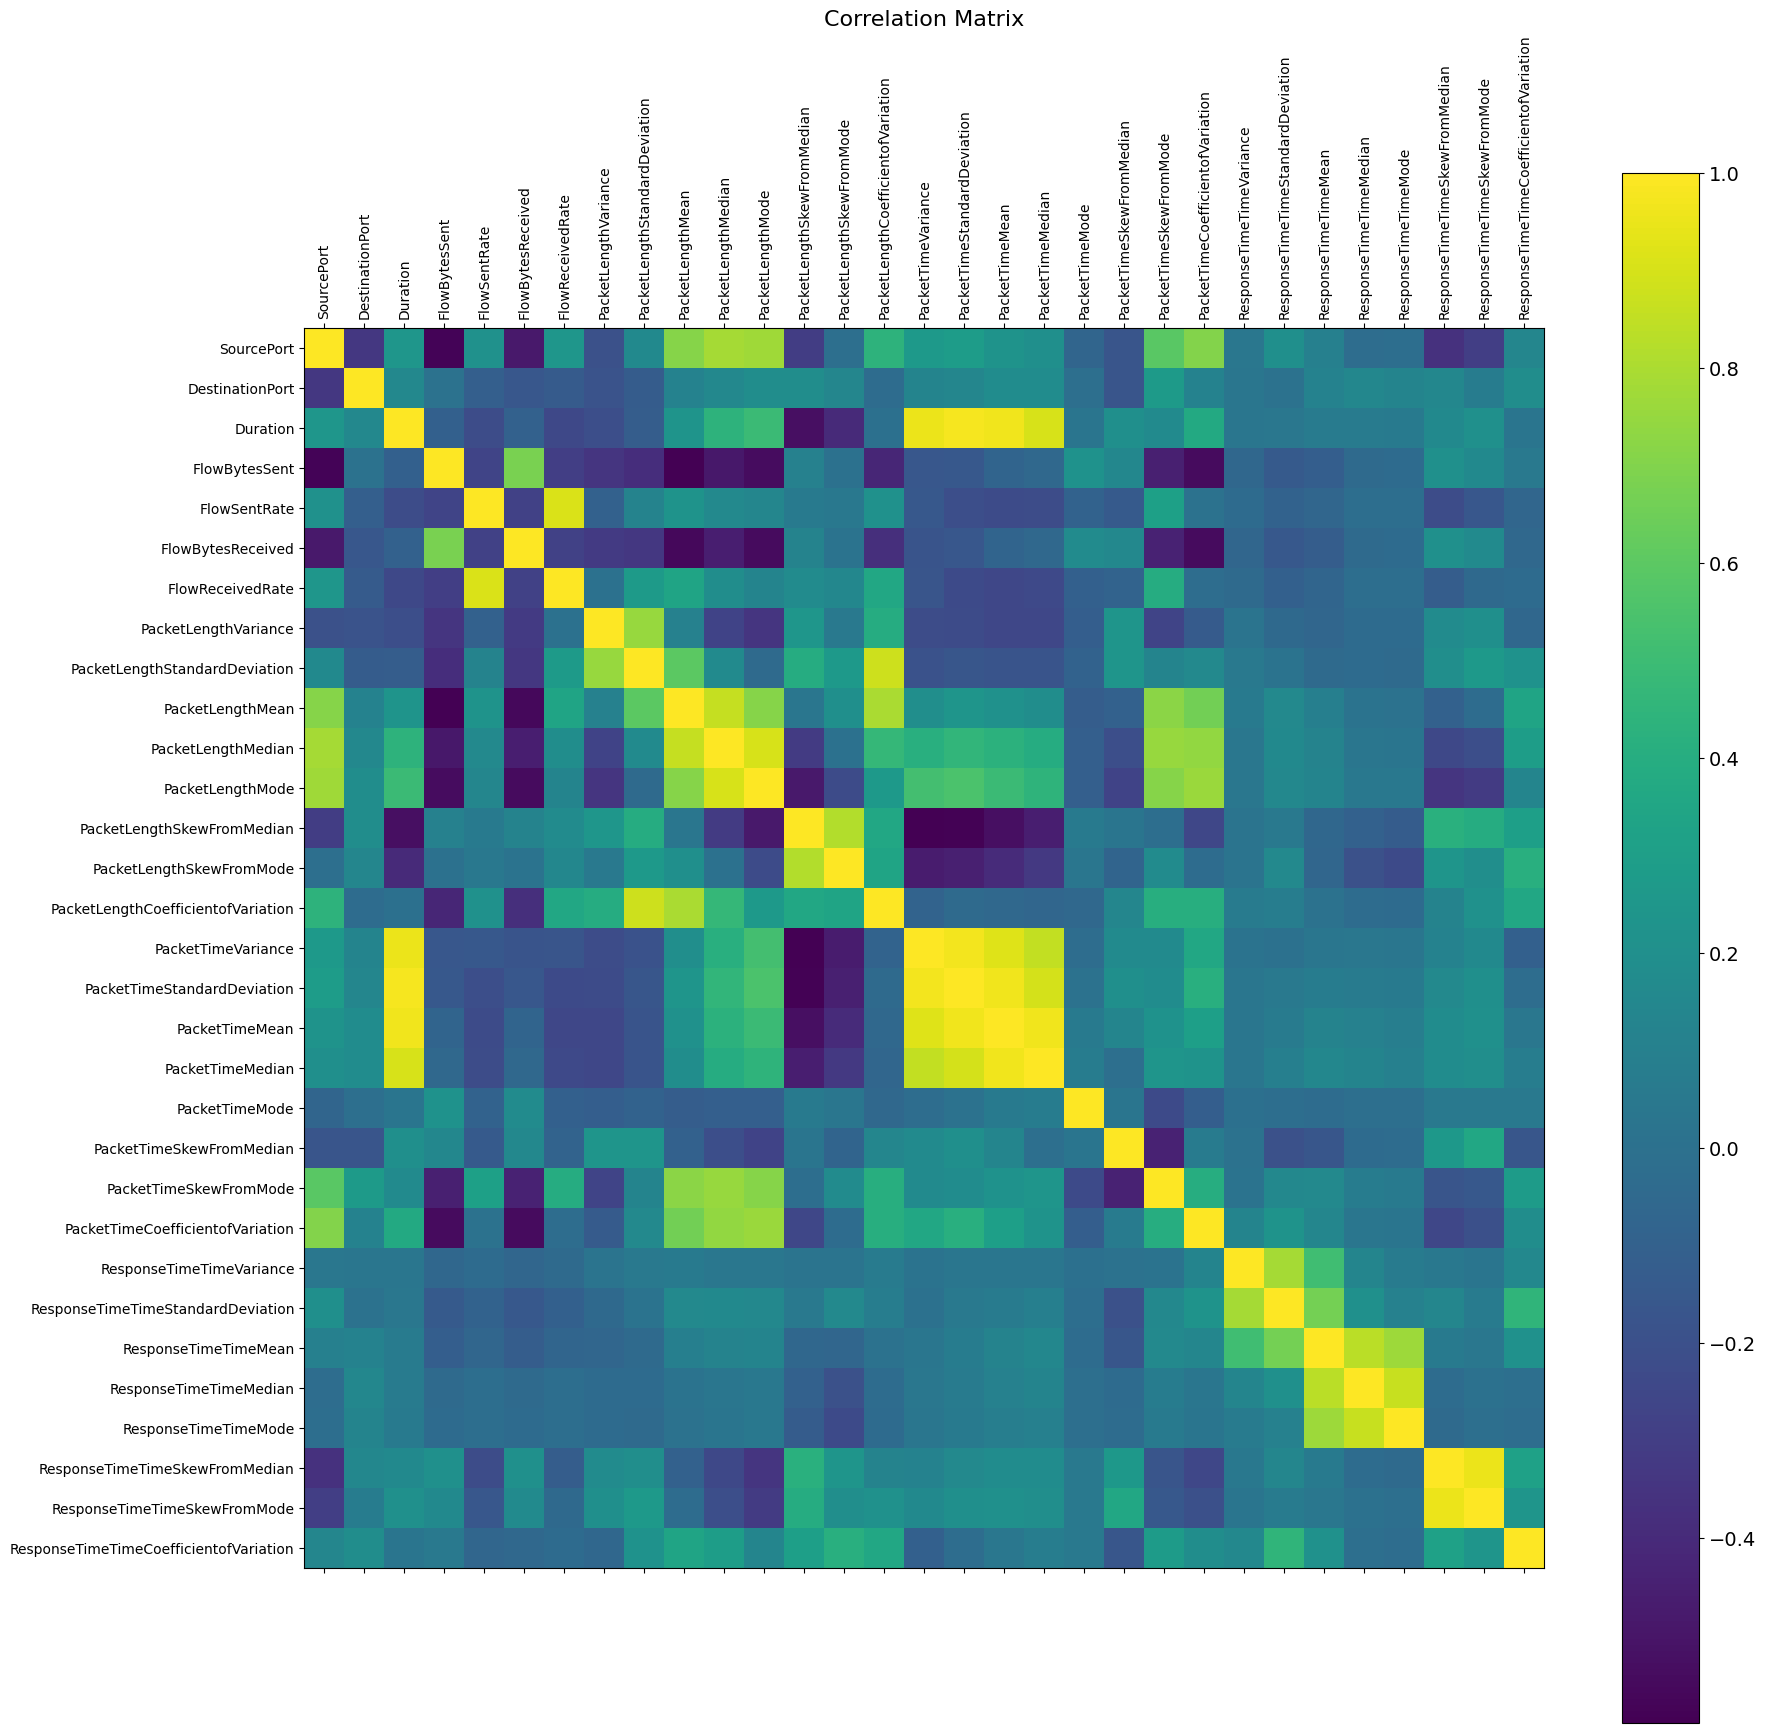

In [328]:
f = plt.figure(figsize = (20,20))
plt.matshow(X_undersam_saved_normalized.corr('pearson'), f.number)
plt.xticks(range(X_undersam_saved_normalized.shape[1]), X_undersam_saved_normalized.columns, fontsize=10, rotation=90)
plt.yticks(range(X_undersam_saved_normalized.shape[1]), X_undersam_saved_normalized.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
plt.show() 

In [27]:
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X_undersam_saved_normalized, y_underSam_saved, 10)
print(str(len(cor_feature)), 'selected features')
print(' ')
print(cor_feature)

10 selected features
 
['FlowSentRate', 'FlowReceivedRate', 'PacketTimeCoefficientofVariation', 'PacketTimeSkewFromMode', 'PacketLengthMean', 'FlowBytesReceived', 'FlowBytesSent', 'PacketLengthMedian', 'PacketLengthMode', 'SourcePort']


## Chi Squared

In [28]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
# X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=10)
chi_selector.fit(abs(X_undersam_saved_normalized), y_underSam_saved)
chi_support = chi_selector.get_support()
chi_feature = X_undersam_saved_normalized.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

print(' ')
print(chi_feature)

10 selected features
 
['SourcePort', 'DestinationPort', 'FlowBytesSent', 'FlowSentRate', 'FlowBytesReceived', 'FlowReceivedRate', 'PacketLengthVariance', 'PacketLengthMedian', 'PacketLengthMode', 'PacketTimeVariance']


## Features To Keep 

With regard to the correlation matrix, the following features were selection to remain in the training dataset. 

In [29]:
X_features_kept = X_undersam_saved_normalized[cor_feature]

In [30]:
from IPython.display import HTML, display

def set_background(color):    
    script = (
        "var cell = this.closest('.jp-CodeCell');"
        "var editor = cell.querySelector('.jp-Editor');"
        "editor.style.background='{}';"
        "this.parentNode.removeChild(this)"
    ).format(color)
    
    display(HTML('<img src onerror="{}" style="display:none">'.format(script)))
    
print(X_features_kept.head(5))

   FlowSentRate  FlowReceivedRate  PacketTimeCoefficientofVariation  \
0      0.006310          0.006618                          0.000006   
1      0.005203          0.005614                          0.000003   
2      0.004286          0.004225                          0.000010   
3      0.005264          0.005923                          0.000006   
4      0.012373          0.011361                          0.000004   

   PacketTimeSkewFromMode  PacketLengthMean  FlowBytesReceived  FlowBytesSent  \
0                0.000016          0.001306           0.629279       0.599942   
1                0.000005          0.000958           0.686599       0.636382   
2                0.000018          0.001787           0.511076       0.518400   
3                0.000011          0.001305           0.654510       0.581662   
4                0.000013          0.001114           0.616115       0.670961   

   PacketLengthMedian  PacketLengthMode  SourcePort  
0            0.000982          0

## t-SNE (After undersampling and feature selection)

In [41]:
# X_res_embedded = TSNE(n_components = 2, random_state = 0).fit_transform(X_features_kept)

In [31]:
# pd.DataFrame(X_res_embedded).to_csv('tsne_feature_selection_1.csv', sep=',')
X_res_embedded_fs = np.array(pd.read_csv('tsne_feature_selection_1.csv', sep=',').drop(columns=['Unnamed: 0']))

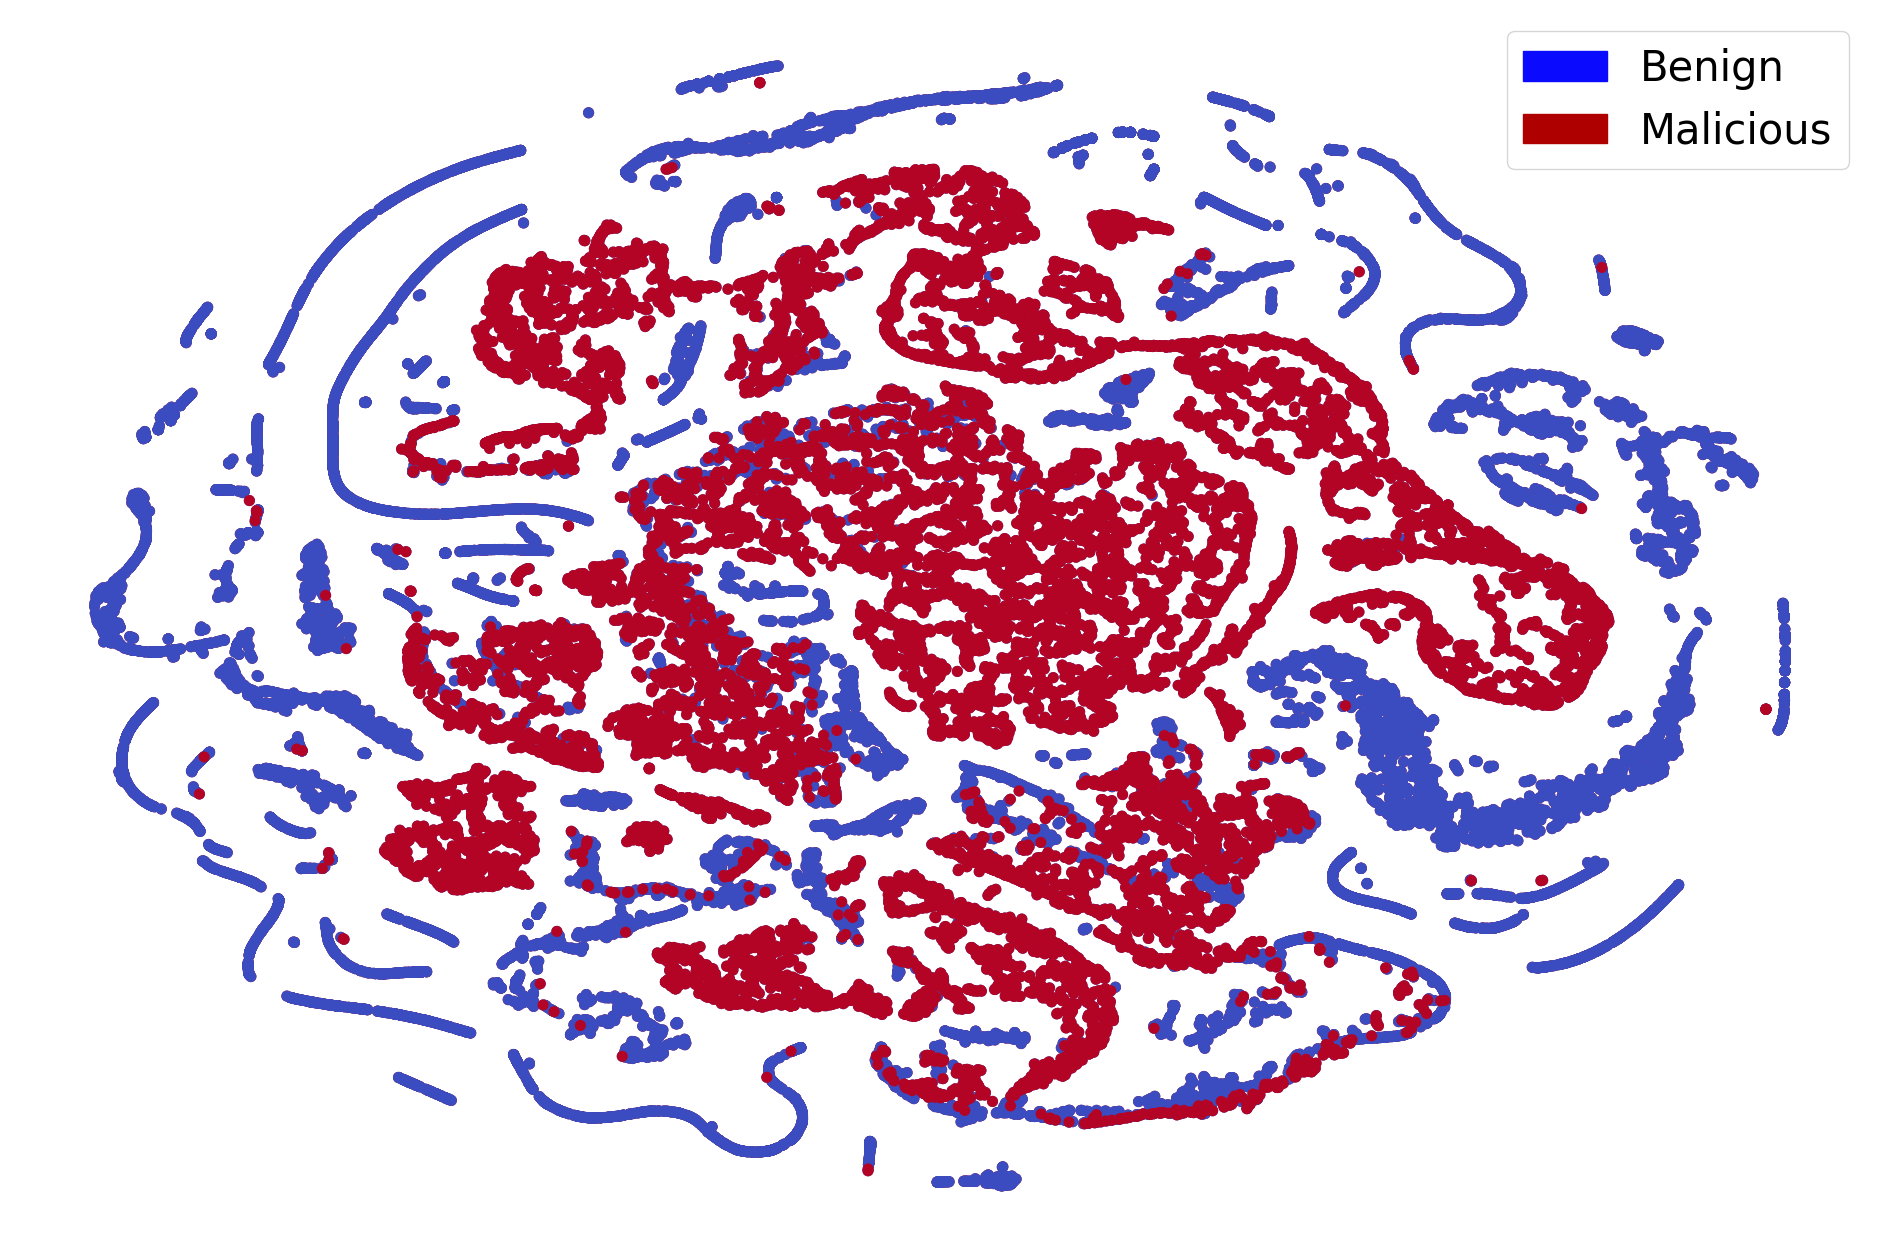

In [116]:
f, ax = plt.subplots(figsize=(24,16))

blue_patch = mpatches.Patch(color='#0A0AFF', label='Benign')
red_patch = mpatches.Patch(color='#AF0000', label='Malicious')

ax.scatter(X_res_embedded_fs[:,0], X_res_embedded_fs[:,1], c=(y_underSam_saved == 0), cmap='coolwarm', label='Benign', linewidths=2)
ax.scatter(X_res_embedded_fs[:,0], X_res_embedded_fs[:,1], c=(y_underSam_saved == 1), cmap='coolwarm', label='Malicious', linewidths=2)
# ax.set_title('t-SNE', fontsize=14)

ax.grid(False)

ax.axis('off')

ax.set_xticks([])
ax.set_yticks([])

ax.legend(handles=[blue_patch, red_patch], fontsize=30)

In [33]:
# X_res_embedded_3d_fs = TSNE(n_components = 3, random_state = 0).fit_transform(X_features_kept)

In [34]:
# pd.DataFrame(X_res_embedded_3d_fs).to_csv('tsne_feature_selection_2.csv', sep=',')
X_res_embedded_3d_fs_saved = np.array(
    pd.read_csv('tsne_feature_selection_2.csv', sep=',').drop(columns=['Unnamed: 0']))

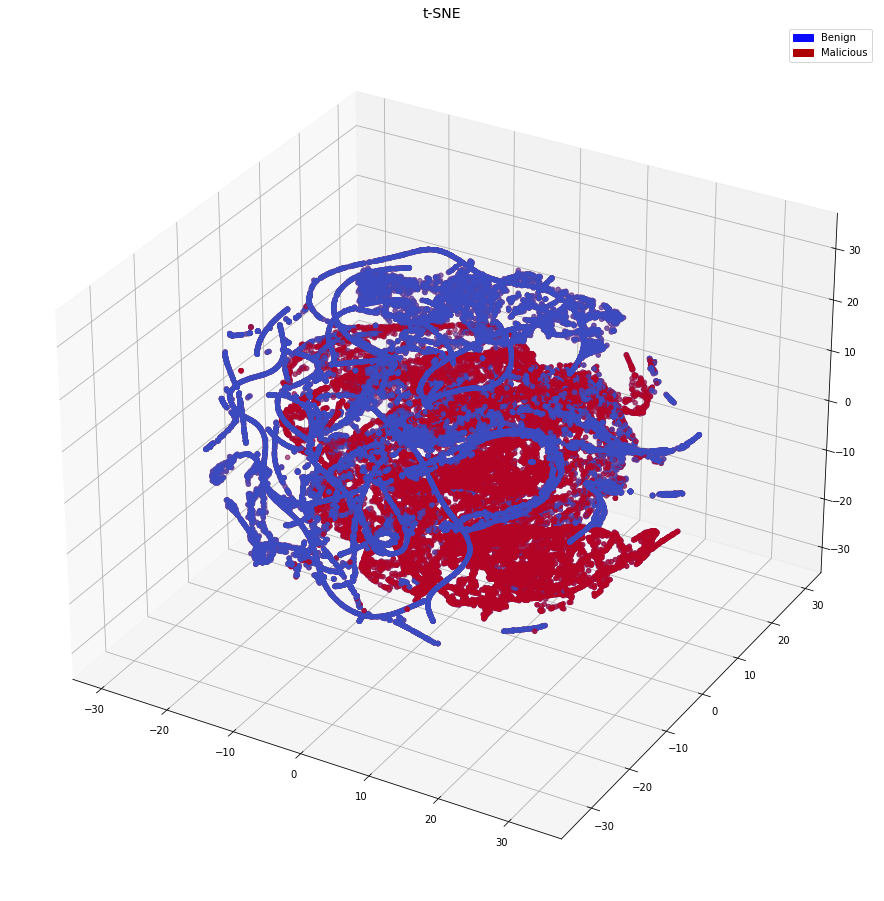

In [35]:
fig = plt.figure(figsize = (24,16))
ax = fig.add_subplot(111, projection='3d')

blue_patch = mpatches.Patch(color='#0A0AFF', label='Benign')
red_patch = mpatches.Patch(color='#AF0000', label='Malicious')

ax.scatter(X_res_embedded_3d_fs_saved[:,0], X_res_embedded_3d_fs_saved[:,1], 
           X_res_embedded_3d_fs_saved[:,2], c=(y_underSam_saved == 0), 
           cmap= 'coolwarm', label='Benign', linewidths=1)
ax.scatter(X_res_embedded_3d_fs_saved[:,0], X_res_embedded_3d_fs_saved[:,1], 
           X_res_embedded_3d_fs_saved[:,2], c=(y_underSam_saved == 1), 
           cmap='coolwarm', label='Malicious', linewidths=1)
ax.set_title('t-SNE', fontsize=14)

ax.grid(True)

ax.legend(handles=[blue_patch, red_patch])

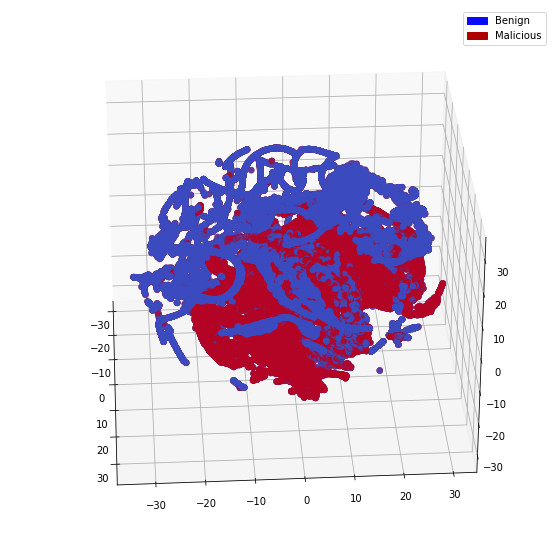

In [47]:
fig = plt.figure(figsize = (15,10))

# plt.style.use('dark_background')

ax = fig.add_subplot(111, projection='3d')

# load some test data for demonstration and plot a wireframe
X, Y, Z = axes3d.get_test_data(0.1)
#ax.grid(False)
#ax.set_axis_off()

blue_patch = mpatches.Patch(color='#0A0AFF', label='Benign')
red_patch = mpatches.Patch(color='#AF0000', label='Malicious')

def init():
    ax.scatter(X_res_embedded_3d_fs_saved[:,0], X_res_embedded_3d_fs_saved[:,1], X_res_embedded_3d_fs_saved[:,2], c=(y_underSam_saved == 0), cmap= 'coolwarm', label='Benign', linewidths=2)
    ax.scatter(X_res_embedded_3d_fs_saved[:,0], X_res_embedded_3d_fs_saved[:,1], X_res_embedded_3d_fs_saved[:,2], c=(y_underSam_saved == 1), cmap='coolwarm', label='Malicious', linewidths=2)
    ax.legend(handles=[blue_patch, red_patch])
    
    ax.grid(True)

    # Hide axes ticks
#     ax.set_xticks([])
#     ax.set_yticks([])

    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

# Animate
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=100, interval=100, blit=True)    

HTML(ani.to_html5_video())

# Classifiers

Three classifiers were trained on the data, a Support Vector Machine, a Random Forest Classifier, and an LSTM Neural Network. 

## Train-test-validation-split

The train-test-validation split selected for training the three classifiers is as follows: 

- Train: 67%
- Test: 22%
- Validation: 11%

In [36]:
X_train , X_test , y_train, y_test = train_test_split(X_features_kept, 
                                                      y_underSam_saved, 
                                                      test_size=0.33, 
                                                      random_state=42)

X_valid , X_test , y_valid, y_test = train_test_split(X_test, 
                                                      y_test, 
                                                      test_size=0.66, 
                                                      random_state=42)

## Support Vector Machine

### Acceptable results

The following hyperparameters lead to optimistic results

```python
svm_model = svm.SVC(C=1.0, gamma=1e4, kernel='rbf') ## 0.93
svm_model = svm.SVC(C=1.0, gamma=1e5, kernel='rbf') ## 0.82
svm_model = svm.SVC(C=1.0, gamma=1e6, kernel='rbf') ## 0.76
svm_model = svm.SVC(C=30.0, gamma=1e6, kernel='rbf') ## 0.76

```

In [37]:
# Normalized Data
svm_model = svm.SVC(C=1.0, gamma=1e4, kernel='rbf')

svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

In [38]:
score = accuracy_score(y_test, y_pred_svm)
print(score)

0.9325738200418507


In [39]:
y_test_pred_svm = svm_model.decision_function(X_test) 

### Plotting SVM training curve

In [323]:
def plot_learning_curve(learning_curve_results):
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))

    ax[0].set_title('Training Scores')
    ax[0].plot(np.linspace(0.6, 1.0, 10), learning_curve_results[1])
    ax[0].plot(np.linspace(0.6, 1.0, 10), learning_curve_results[1], 'ro')
    ax[0].grid(color='black', linestyle='-', linewidth=0.1)
    ax[0].set_xlabel('Train size')
    ax[0].set_ylabel('Accuracy Score')

    ax[1].set_title('Test Scores')
    ax[1].plot(1 - np.linspace(0.6, 1.0, 10), learning_curve_results[2])
    ax[1].plot(1 - np.linspace(0.6, 1.0, 10), learning_curve_results[2], 'ro')
    ax[1].grid(color='black', linestyle='-', linewidth=0.1)
    ax[1].set_xlabel('test size')
    ax[1].set_ylabel('Accuracy Score')

    plt.show()

In [324]:
svm_learning_curve_data = learning_curve(svm_model, 
                                         X_undersam_saved, 
                                         y_underSam_saved, 
                                         n_jobs=-1, 
                                         train_sizes=np.linspace(0.6, 1.0, 10),
                                         random_state=42)

In [325]:
svm_learning_curve_data

(array([18955, 20359, 21764, 23168, 24572, 25976, 27380, 28784, 30188,
        31593]),
 array([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]]),
 array([[0.5000633, 0.4999367, 0.5      , 0.5      , 0.5      ],
        [0.5000633, 0.4999367, 0.5      , 0.5      , 0.5      ],
        [0.5000633, 0.4999367, 0.5      , 0.5      , 0.5      ],
        [0.5000633, 0.4999367, 0.5      , 0.5      , 0.5      ],
        [0.5000633, 0.4999367, 0.5      , 0.5      , 0.5      ],
        [0.5000633, 0.4999367, 0.5      , 0.5      , 0.5      ],
        [0.5000633, 0.4999367, 0.5      , 0.5      , 0.5      ],
        [0.5000633, 0.4999367, 0.5      , 0.5      , 0.5      ],
        [0.5000633, 0.4999367, 0.5      , 0.5      , 0.5      ],
        [0.5001899, 0.500

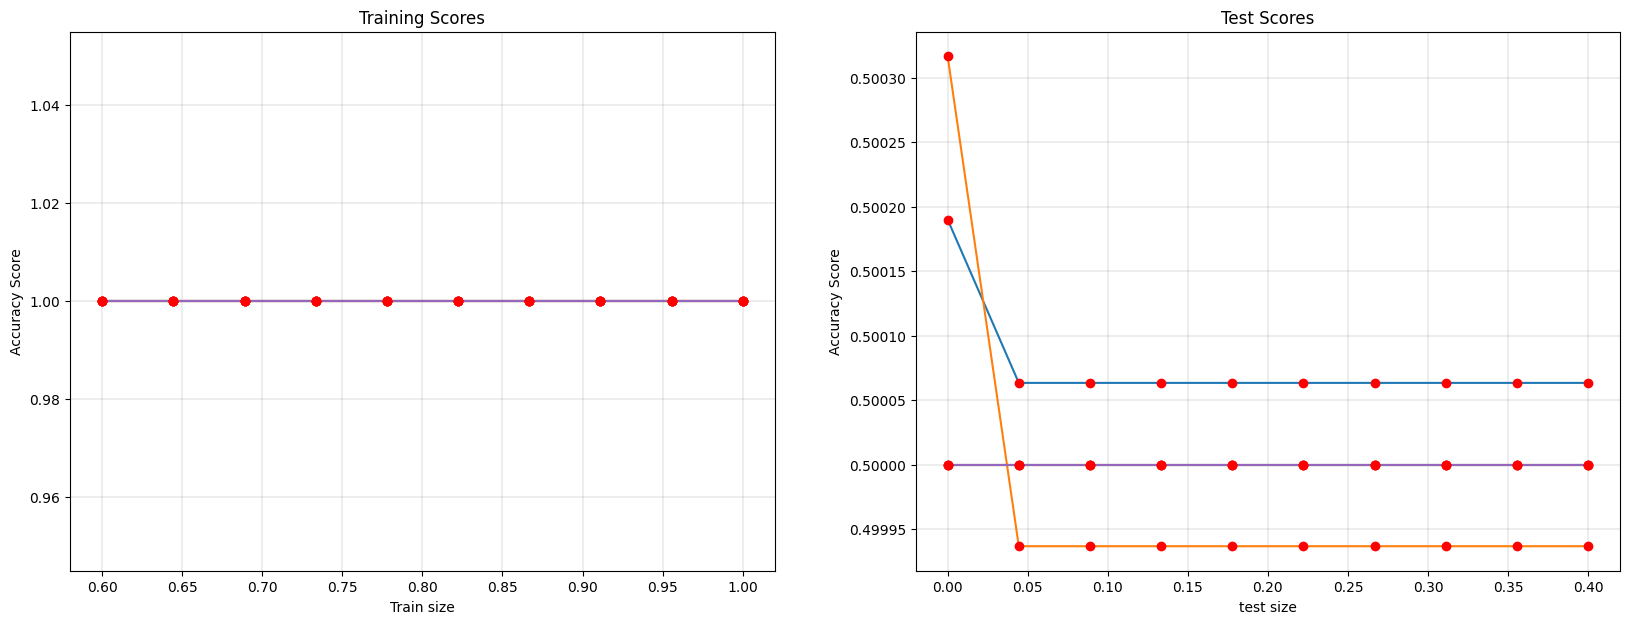

In [326]:
plot_learning_curve(svm_learning_curve_data)

## Random Forest Classifier

In [42]:
rfc_model = RandomForestClassifier(n_estimators=50)

rfc_model.fit(X_train, y_train)
y_pred_rfc = rfc_model.predict(X_test)

In [43]:
score = accuracy_score(y_test, y_pred_rfc)
print(score)

0.9840734712857475


### Plotting RFC Training curves

In [58]:
rfc_learning_curve_data = learning_curve(rfc_model, 
                                         X_undersam_saved, 
                                         y_underSam_saved,
                                         train_sizes=np.linspace(0.6, 1.0, 10),
                                         n_jobs=-1, 
                                         random_state=42)

/Users/ahmadchaiban/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


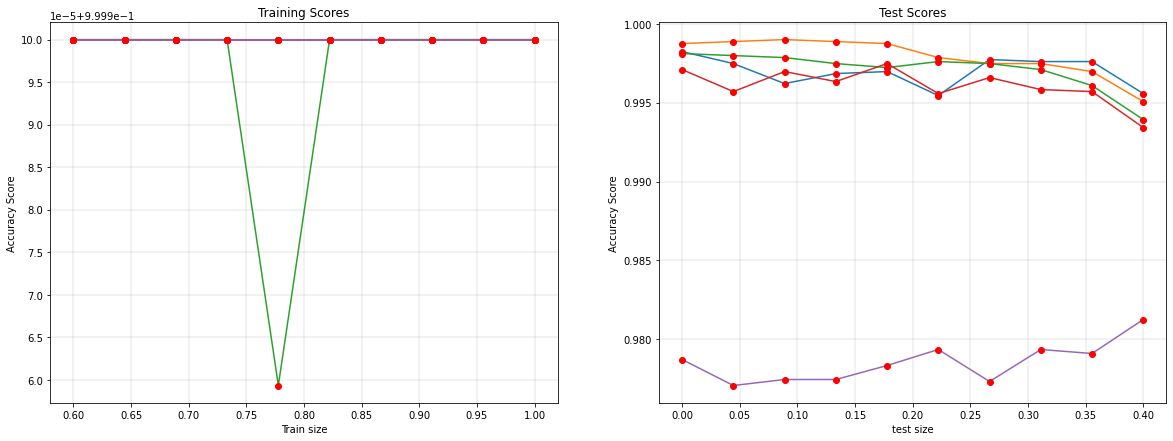

In [59]:
plot_learning_curve(rfc_learning_curve_data)

## LSTM Neural Network

In [44]:
X_train_lstm = np.array(X_train).reshape([X_train.shape[0], X_train.shape[1], 1])
X_valid_lstm = np.array(X_valid).reshape([X_valid.shape[0], X_valid.shape[1], 1])
X_test_lstm = np.array(X_test).reshape([X_test.shape[0], X_test.shape[1], 1])

In [288]:
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, Dense, LSTM, Input, Embedding, SpatialDropout1D, Dropout
from tensorflow.keras import Model, Sequential


# lstm_model = Sequential()
# lstm_model.add(Embedding(964, 10))
# lstm_model.add(SpatialDropout1D(0.2))
# lstm_model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
# lstm_model.add(Dense(10, activation = 'sigmoid'))
# lstm_model.add(Dense(1, activation = 'sigmoid'))

# lstm_model.compile(loss='bce', optimizer='rmsprop', metrics=['accuracy'])


lstm_model = Sequential([
#     LSTM(256, return_sequences=True, input_shape=([10, 1])),
#     Dropout(0.7),
#     LSTM(256, return_sequences=True, input_shape=([10, 1])),
#     Dropout(0.7),
#     LSTM(128, return_sequences=True),
#     Dropout(0.2),
    LSTM(64, return_sequences=True, input_shape=([10, 1])),
    Dropout(0.2),
    LSTM(32, return_sequences=True),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(lstm_model.summary())

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_63 (LSTM)               (None, 10, 64)            16896     
_________________________________________________________________
dropout_53 (Dropout)         (None, 10, 64)            0         
_________________________________________________________________
lstm_64 (LSTM)               (None, 10, 32)            12416     
_________________________________________________________________
dense_23 (Dense)             (None, 10, 1)             33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________
None


In [318]:
# history_lstm = lstm_model.fit(
#     X_train_lstm,
#     y_train,
#     epochs=1000,
#     batch_size=128,
#     validation_data=(X_valid_lstm, y_valid))

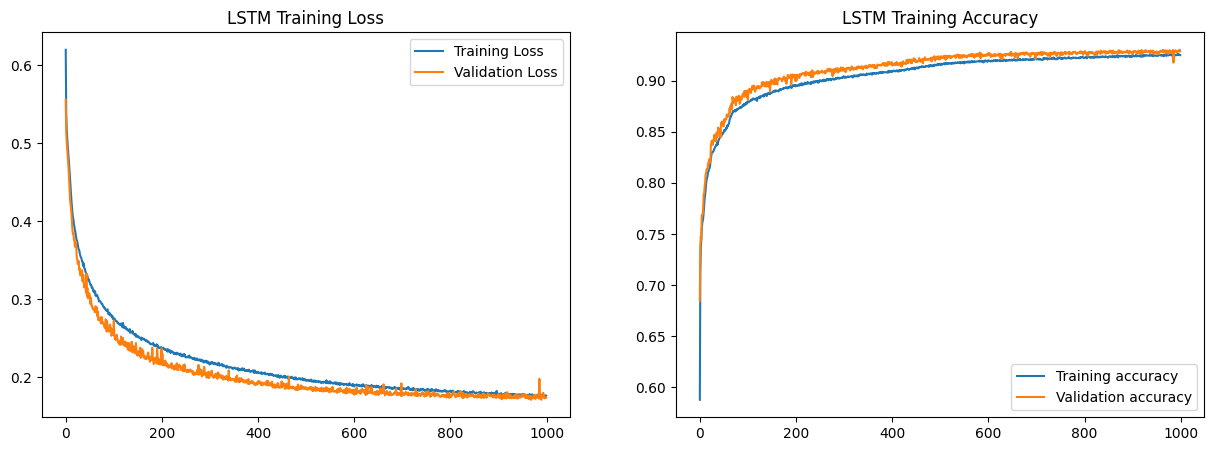

In [290]:
f, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(history_lstm.history['loss'])
ax1.plot(history_lstm.history['val_loss'])
ax1.set_title('LSTM Training Loss')
ax1.legend(['Training Loss', 'Validation Loss'], loc='upper right')

ax2.plot(history_lstm.history['accuracy'])
ax2.plot(history_lstm.history['val_accuracy'])
ax2.set_title('LSTM Training Accuracy')
ax2.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')

f.set_figheight(5)
f.set_figwidth(15)

In [293]:
y_pred_lstm = lstm_model.predict_classes(X_test_lstm)[:, 0]
accuracy_score(y_test, y_pred_lstm)

0.7877237851662404

In [294]:
y_pred_prob_lstm = lstm_model.predict(X_test_lstm)[:, 0]

In [301]:
lstm_model.save('./lstm_model.h5')

## Neural Network 2

In [267]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Sequential

nn_model = Sequential([
    Dense(50, input_shape=[X_train.shape[1]], activation='sigmoid'),
    Dropout(0.4),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
    
])

nn_model.compile(loss='bce', optimizer='adam', metrics=['accuracy'])

print(nn_model.summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 50)                550       
_________________________________________________________________
dropout_50 (Dropout)         (None, 50)                0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 51        
Total params: 601
Trainable params: 601
Non-trainable params: 0
_________________________________________________________________
None


In [319]:
# history_nn = nn_model.fit(
#     X_train,
#     y_train,
#     epochs=1000,
#     batch_size=32,
#     validation_data=(X_valid, y_valid))

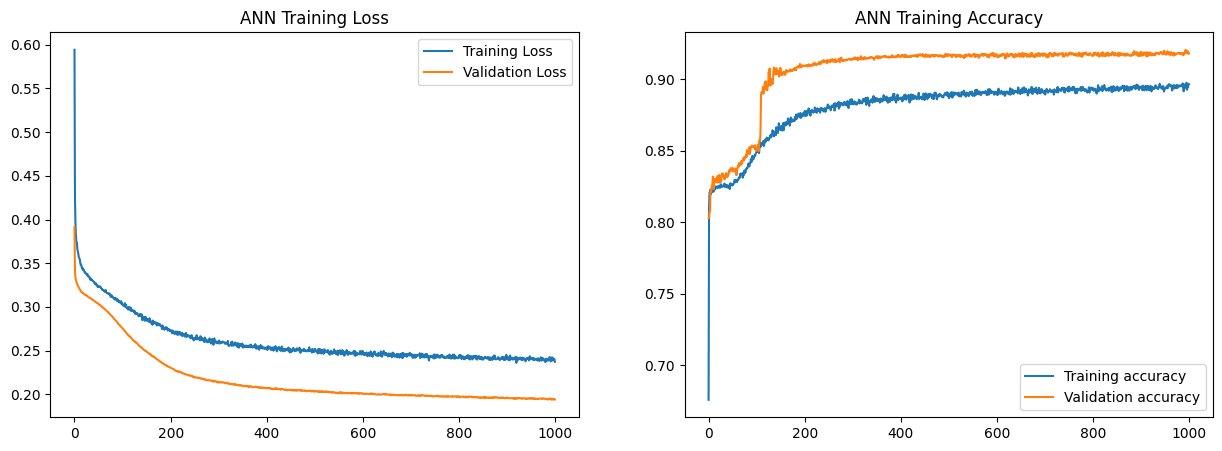

In [313]:
f, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(history_nn.history['loss'])
ax1.plot(history_nn.history['val_loss'])
ax1.set_title('ANN Training Loss')
ax1.legend(['Training Loss', 'Validation Loss'], loc='upper right')

ax2.plot(history_nn.history['accuracy'])
ax2.plot(history_nn.history['val_accuracy'])
ax2.set_title('ANN Training Accuracy')
ax2.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')

f.set_figheight(5)
f.set_figwidth(15)

In [297]:
nn_model.predict(X_test).shape

(8602, 1)

In [298]:
y_pred_nn2 = nn_model.predict_classes(X_test)
y_pred_prob_nn2 = nn_model.predict(X_test)

In [299]:
accuracy_score(y_test, y_pred_nn2)

0.9150197628458498

In [300]:
nn_model.save('./nn_model.h5')

# Classifier Evaluation

## Recall: SVM, RFC, LSTM & ANN

### Confusion Matrices

In [302]:
from sklearn.metrics import confusion_matrix 

print('Confusion Matrix for SVM')
print(confusion_matrix(y_test, y_pred_svm))

print('Confusion Matrix for RFC')
print(confusion_matrix(y_test, y_pred_rfc))

print('Confusion Matrix for LSTM')
print(confusion_matrix(y_test, y_pred_lstm))

print('Confusion Matrix for ANN')
print(confusion_matrix(y_test, y_pred_nn2))

Confusion Matrix for SVM
[[3877  494]
 [  86 4145]]
Confusion Matrix for RFC
[[4283   88]
 [  49 4182]]
Confusion Matrix for LSTM
[[3217 1154]
 [ 672 3559]]
Confusion Matrix for ANN
[[3800  571]
 [ 160 4071]]


### ROC (Receiver Operating Characteristic) Curves

In [303]:
def plot_roc(model):
    ax = plt.gca()
    disp = plot_roc_curve(model, X_test, y_test, ax=ax, alpha=0.8, linewidth=5)
    return disp

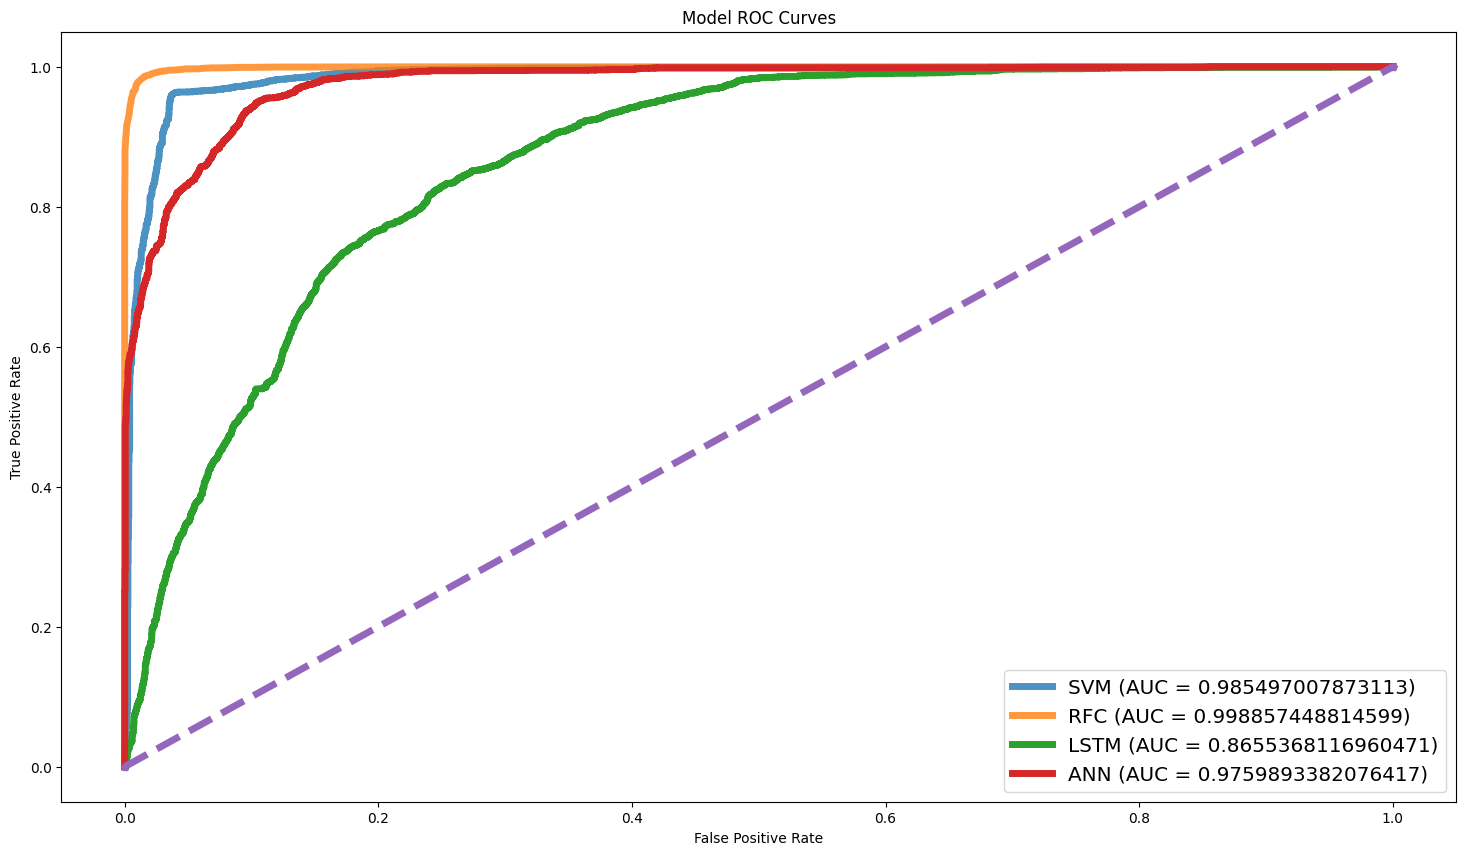

In [304]:
from sklearn.metrics import roc_curve, auc, plot_roc_curve

plt.style.use('default')

plt.figure(figsize=(18,10))

plt.title('Model ROC Curves')

## SVM
svc_disp = plot_roc(svm_model)

## RFC 
rfc_disp = plot_roc(rfc_model)

## LSTM
test_fpr_lstm, test_tpr_lstm, te_thresholds_lstm = roc_curve(y_test, y_pred_prob_lstm)
auc_lstm = auc(test_fpr_lstm, test_tpr_lstm)
plt.plot(test_fpr_lstm, test_tpr_lstm, linewidth=5)

## ANN
test_fpr_ann, test_tpr_ann, te_thresholds_ann = roc_curve(y_test, y_pred_prob_nn2)
auc_ann = auc(test_fpr_ann, test_tpr_ann)
plt.plot(test_fpr_ann, test_tpr_ann, linewidth=5)

plt.plot([0,1], [0,1], 'p--', linewidth=5)

plt.legend([f'SVM (AUC = {svc_disp.roc_auc})', 
            f'RFC (AUC = {rfc_disp.roc_auc})', 
            f'LSTM (AUC = {auc_lstm})', 
            f'ANN (AUC = {auc_ann})'], 
           loc='lower right', fontsize='x-large')

plt.show()

## Testing on Original Data Unsampled data

### SVM

In [305]:
X_full_normalized = pd.DataFrame(normalize(original_features, norm='l2', axis=1))
X_full_normalized.columns = X_undersam_saved.columns

In [306]:
X_features_kept_full = X_full_normalized[cor_feature]

y_pred_svm_full = svm_model.predict(X_features_kept_full)

print(accuracy_score(y, y_pred_svm_full))

0.9409244000163387


### RFC

In [307]:
y_pred_rfc_full = rfc_model.predict(X_features_kept_full)
print(accuracy_score(y, y_pred_rfc_full))

0.9867062261649691


### LSTM

In [308]:
X_features_kept_full_lstm = np.array(X_features_kept_full).reshape(X_features_kept_full.shape[0], 
                                                                   X_features_kept_full.shape[1], 
                                                                   1)

In [320]:
y_pred_lstm_full = lstm_model.predict_classes(X_features_kept_full_lstm)[:, 0]

accuracy_score(y, y_pred_lstm_full)

0.4772353406436712

### ANN

In [310]:
y_pred_nn_full = nn_model.predict_classes(X_features_kept_full)
accuracy_score(y, y_pred_nn_full)

0.7653983119135236

## Confusion matrices for whole dataset

In [311]:
from sklearn.metrics import confusion_matrix 

print('Confusion Matrix for SVM on full data')
print(confusion_matrix(y, y_pred_svm_full))

print('Confusion Matrix for RFC on full data')
print(confusion_matrix(y, y_pred_rfc_full))

print('Confusion Matrix for LSTM on full data')
print(confusion_matrix(y, y_pred_lstm_full))

print('Confusion Matrix for ANN on full data')
print(confusion_matrix(y, y_pred_nn_full))

Confusion Matrix for SVM on full data
[[ 18735   1011]
 [ 14898 234655]]
Confusion Matrix for RFC on full data
[[ 19612    134]
 [  3446 246107]]
Confusion Matrix for LSTM on full data
[[ 14461   5285]
 [135495 114058]]
Confusion Matrix for ANN on full data
[[ 17089   2657]
 [ 60521 189032]]


# Prevention

The following basic rules serve as a good compliment to the ML pipeline. 

In [265]:
import random
from stix2 import Indicator


#Global Value to ensure, we are not re-using the SID's within snort/suricate
sids = []


# Generates a random number within the local SID range of Snort.
# validation to make sure we do not reuse the same random twice within SIDS.
# Returns SID in string format.
def generateSID():
    sid = random.randrange(5000001, 6000000)
    if sid not in sids:
        sids.append(str(sid))
        return str(sid)
    else:
        generateSID()

# Suricata is an open source-based intrusion detection system and intrusion prevention system.
# Input:  URL and unique Sid for rule definition
# Output: string containing drop rule for passed URL
def generateSuricata(url,sid):
    return  'drop dns any any -> any any (msg:"6520 AI Malciious Detection"; content:"'+ url \
+'"; classtype:policy-violation; sid:'+ sid +'; rev:1;)','drop tls any any -> any any (msg:\
"6520 AI Malciious Detection"; tls.subject:"'+ url +'"; classtype:policy-violation; sid:'+ sid +'; rev:1;)'

# Snort is a free open source network intrusion detection system and intrusion prevention system
# Input: URL and unique Sid for rule definition
# Output: string containing drop rule for passed URL
def generateSnort(url,sid):
    return 'drop tcp any any -> any any (content:"' + url + '"; msg:"6520 AI Malciious Detection"; \
    sid:'+sid+'; rev:1;)'


In [327]:
# YARA is a tool aimed at (but not limited to) helping malware researchers to identify and classify malware samples
# Input: URL and unique Sid for rule definition
# Output: Basic yara rule to detect malcious URL withing memory
def generateYara(url,sid):
    yara_base = '''
    rule 6520_AI_YYYYY
    {​​​​​​​
    meta:
        description = "6520 AI Malciious Detection"
        threat_level = 0
        in_the_wild = true


    strings:
        $url = "XXXXX" wide ascii


    condition:
        $url
    }​​​​​​​
    '''
    rule = yara_base.replace('YYYYY', sid)
    rule = rule.replace('XXXXX', url)
    return rule

# Structured Threat Information Expression (STIX™) is a language and 
# serialization format used to exchange cyber threat intelligence (CTI).

# Input: URL
# Output: STIX2 indicator object containing suspicious URL
def generateSTIX(url):
    indicator = Indicator(
        indicator_types=['malicious-activity'],
        pattern_type="stix",
        pattern="[domain-name:value = \'"+url+"\']",
        valid_from="2021-04-30T12:34:56Z")
    return indicator

#
# Testing class to demonstrate the output of above functions
#
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
   
#OUTPUT
print(f"{​​​​​​​bcolors.WARNING}​​​​​​​ \nSNORT{​​​​​​​bcolors.ENDC}​​​​​​​")
print(generateSnort("http://www.google.ca", generateSID()))
print(f"{​​​​​​​bcolors.WARNING}​​​​​​​ \nSURICATA{​​​​​​​bcolors.ENDC}​​​​​​​")
print(generateSuricata("http://www.google.ca", generateSID()))
print(f"{​​​​​​​bcolors.WARNING}​​​​​​​ \nYARA{​​​​​​​bcolors.ENDC}​​​​​​​")
print(generateYara("http://www.google.ca", generateSID()))
print(f"{​​​​​​​bcolors.WARNING}​​​​​​​ \nSTIX/TAXII{​​​​​​​bcolors.ENDC}​​​​​​​")
print(generateSTIX("https://www.google.ca"))